In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize


In [ ]:
file = pd.read_excel("/content/drive/MyDrive/Data_Euro_Stoxx.xlsx",sheet_name="Sheet2")


dates=file.iloc[:,0]
file = file.set_index(dates)
file = file.iloc[1:,:]

file.dropna(axis=1,inplace=True)

file.index.name=None

file.columns = ["SXXT","SXNT","SX7T","SX4T","SXQT","SXIT","SX8T","SXAT","SXDT","SX3T","SX6T","SXKT","SXET","SXMT","SXRT","SXTT","SXFT","SXPT"]

eurostoxx = file["SXXT"]


file.drop(['SXXT'], axis=1,inplace=True)


new_index = {file.index[0]: '1992-01-01 00:00:00'}
file = file.rename(index=new_index)






def calculate_returns(prices):
    return prices.pct_change().dropna()

def calculate_covariance_matrix(returns):
    return returns.cov()

def erc_objective_function(weights, cov_matrix):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    risk_contributions = weights * (np.dot(cov_matrix, weights)) / portfolio_variance
    return np.sum((risk_contributions - np.mean(risk_contributions)) ** 2)

def erc_weights(prices):
    returns = calculate_returns(prices)
    cov_matrix = calculate_covariance_matrix(returns)
    num_assets = cov_matrix.shape[0]
    initial_weights = np.repeat(1 / num_assets, num_assets)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'ineq', 'fun': lambda w: w})
    result = minimize(erc_objective_function, initial_weights, args=(cov_matrix,), method='SLSQP', constraints=constraints)



    return result.x



def backtest_erc(prices, window_size=60, days_per_month=21):
    num_periods = prices.shape[0] - window_size
    portfolio_values = [1.0]
    weights = None

    for i in range(num_periods):
        sub_prices = prices.iloc[i:i+window_size, :]

        # Rééquilibrer le portefeuille si c'est le premier jour ou si la fréquence de rééquilibrage est atteinte
        if i % days_per_month == 0:
            weights = erc_weights(sub_prices)

        sub_returns = calculate_returns(sub_prices)
        period_return = np.dot(weights, sub_returns.iloc[-1, :])
        portfolio_values.append(portfolio_values[-1] * (1 + period_return))

    return pd.Series(portfolio_values, index=prices.index[:len(portfolio_values)])

















/usr/local/lib/python3.9/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


NaT              100
1992-01-02    100.28
1992-01-03    100.03
1992-01-06    101.56
1992-01-07    101.55
               ...  
2018-01-23    774.68
2018-01-24    768.31
2018-01-25    765.23
2018-01-26    769.16
2018-01-29    769.16
Name: SXXT, Length: 6804, dtype: object


In [ ]:


def equally_weighted_weights(prices):
    num_assets = prices.shape[1]
    weights = np.repeat(1 / num_assets, num_assets)
    return weights

def backtest_equally_weighted(prices, window_size=60, days_per_month=21):
    num_periods = prices.shape[0] - window_size
    portfolio_values = [1.0]
    weights = None

    for i in range(num_periods):
        sub_prices = prices.iloc[i:i+window_size, :]

        # Rééquilibrer le portefeuille si c'est le premier jour ou si la fréquence de rééquilibrage est atteinte
        if i % days_per_month == 0:
            weights = equally_weighted_weights(sub_prices)

        sub_returns = calculate_returns(sub_prices)
        period_return = np.dot(weights, sub_returns.iloc[-1, :])
        portfolio_values.append(portfolio_values[-1] * (1 + period_return))

    return pd.Series(portfolio_values, index=prices.index[:len(portfolio_values)])

# Exemple d'utilisation :



In [ ]:


def min_variance_objective_function(weights, cov_matrix):
    return (np.dot(weights.T, np.dot(cov_matrix, weights)))

def min_variance_weights(prices, init_weights=None):
    returns = calculate_returns(prices)
    cov_matrix = calculate_covariance_matrix(returns)
    num_assets = cov_matrix.shape[0]

    if init_weights is None:
        initial_weights = np.repeat(1 / num_assets, num_assets)
    else:
        initial_weights = init_weights

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'ineq', 'fun': lambda w: w})
    result = minimize(min_variance_objective_function, initial_weights, args=(cov_matrix,), method='SLSQP', constraints=constraints)


    return result.x

def backtest_MV(prices, window_size=60, days_per_month=21):
    num_periods = prices.shape[0] - window_size
    portfolio_values3 = [1.0]
    weights = None

    for i in range(num_periods):
        sub_prices = prices.iloc[i:i+window_size, :]

        # Rééquilibrer le portefeuille si c'est le premier jour ou si la fréquence de rééquilibrage est atteinte
        if i % days_per_month == 0:
            weights = min_variance_weights(sub_prices, init_weights=weights)

        sub_returns = calculate_returns(sub_prices)
        period_return = np.dot(weights, sub_returns.iloc[-1, :])
        portfolio_values3.append(portfolio_values3[-1] * (1 + period_return))

    return pd.Series(portfolio_values3, index=prices.index[:len(portfolio_values3)])





In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt




portfolio_values3 = backtest_MV(file)
print("Valeurs du portefeuille :", portfolio_values3)

portfolio_values2 = backtest_equally_weighted(file)
print("Valeurs du portefeuille :", portfolio_values2)

portfolio_values1 = backtest_erc(file)
print("Valeurs du portefeuille :", portfolio_values1)



Valeurs du portefeuille : 1992-01-01 00:00:00     1.000000
1992-01-02 00:00:00     0.999393
1992-01-03 00:00:00     1.003694
1992-01-06 00:00:00     1.006656
1992-01-07 00:00:00     1.003551
                         ...    
2017-11-01 00:00:00    13.288168
2017-11-02 00:00:00    13.336722
2017-11-03 00:00:00    13.214640
2017-11-06 00:00:00    13.128615
2017-11-07 00:00:00    13.220685
Length: 6745, dtype: float64
Valeurs du portefeuille : 1992-01-01 00:00:00    1.000000
1992-01-02 00:00:00    0.999393
1992-01-03 00:00:00    1.003694
1992-01-06 00:00:00    1.006656
1992-01-07 00:00:00    1.003551
                         ...   
2017-11-01 00:00:00    9.786620
2017-11-02 00:00:00    9.801441
2017-11-03 00:00:00    9.724429
2017-11-06 00:00:00    9.675746
2017-11-07 00:00:00    9.728098
Length: 6745, dtype: float64
Valeurs du portefeuille : 1992-01-01 00:00:00     1.000000
1992-01-02 00:00:00     0.999228
1992-01-03 00:00:00     1.003266
1992-01-06 00:00:00     1.006309
1992-01-07 00:00:

/usr/local/lib/python3.9/dist-packages/seaborn/_oldcore.py:835: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  wide_data["@index"] = wide_data.index.to_series()


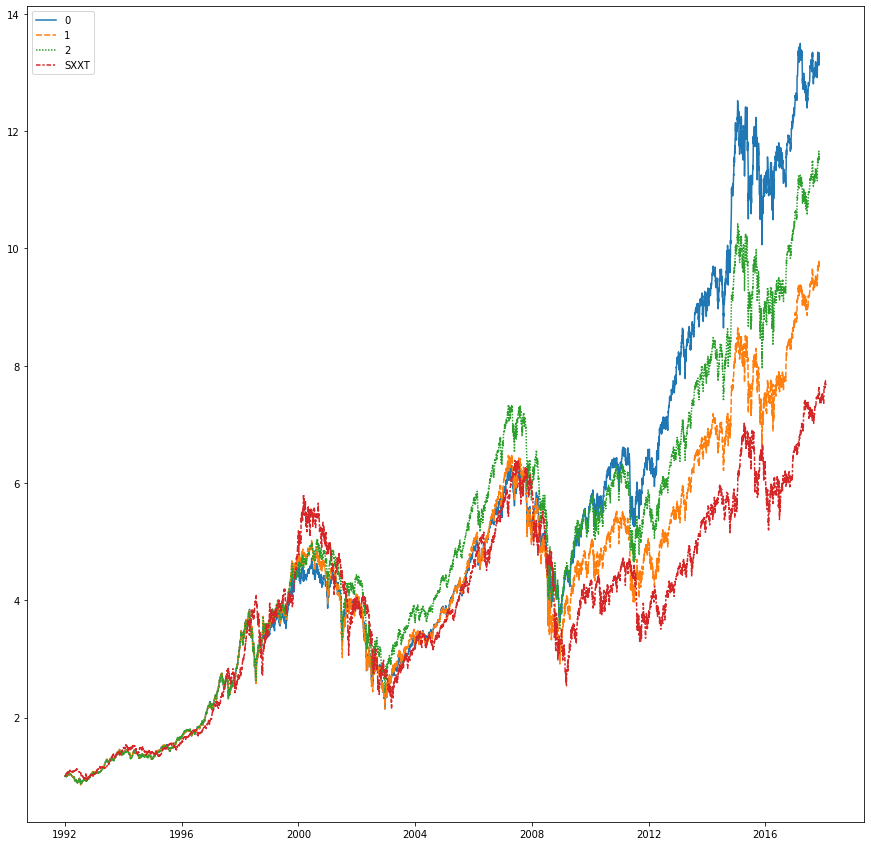

In [ ]:



return_eurostoxx = calculate_returns(eurostoxx)
portfolio_eurostoxx = np.cumprod(1 + return_eurostoxx)





merged_series = pd.concat([portfolio_values3,portfolio_values2,portfolio_values1,portfolio_eurostoxx], axis=1)



plt.figure(figsize=(15, 15))
sns.lineplot(data=merged_series)

plt.show()


In [ ]:
def calculate_returns(prices):
    return prices.pct_change().dropna()


def estimate_volatility(prices):
    returns = calculate_returns(prices)
    volatility = returns.std()
    return volatility



volatility = estimate_volatility(portfolio_values1)
print("Volatilité estimée  erc :", volatility)

volatility = estimate_volatility(portfolio_values2)
print("Volatilité estimée 1/n :", volatility)

volatility = estimate_volatility(portfolio_values3)
print("Volatilité estimée MV :", volatility)


def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
    excess_returns = returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / excess_returns.std()
    return sharpe_ratio





erc_returns = calculate_returns(portfolio_values1)
ew_returns = calculate_returns(portfolio_values2)
mv_returns = calculate_returns(portfolio_values3)


erc_sharpe_ratio = calculate_sharpe_ratio(portfolio_values1)
ew_sharpe_ratio = calculate_sharpe_ratio(portfolio_values2)
mv_sharpe_ratio = calculate_sharpe_ratio(portfolio_values3)

print("Sharpe Ratio (erc) :", erc_sharpe_ratio)
print("Sharpe Ratio (ew) :", ew_sharpe_ratio)
print("Sharpe Ratio (Mv) :", mv_sharpe_ratio)






Volatilité estimée  erc : 0.011129704378180534
Volatilité estimée 1/n : 0.01178619210643984
Volatilité estimée MV : 0.01089354058682371
Sharpe Ratio (erc) : 1.841245193952117
Sharpe Ratio (ew) : 2.0161141208282483
Sharpe Ratio (Mv) : 1.5565723158944165


In [ ]:


def calculate_correlation_matrix(returns):
    return returns.corr()

# Simuler des données de prix pour les actifs


# Calculer les rendements, la covariance et la matrice de corrélation
returns = calculate_returns(file)
cov_matrix = calculate_covariance_matrix(returns)
correlation_matrix = calculate_correlation_matrix(returns)

# Calculer les rendements moyens, les volatilités et les corrélations entre les rendements des actifs
mean_returns = returns.mean()
volatilities = returns.std()

# Créer un tableau à trois colonnes pour chaque actif
result = pd.DataFrame(columns=["Mean Return", "Volatility", "Correlations"])

for asset in returns.columns:
    result.loc[asset, "Mean Return"] = mean_returns[asset]
    result.loc[asset, "Volatility"] = volatilities[asset]
    result.loc[asset, "Correlations"] = [correlation_matrix[asset][other_asset] if other_asset != asset else 1 for other_asset in returns.columns]


result.head()

,Mean Return,Volatility,Correlations
SXNT,0.000485,0.013355,"[1, 0.766154121725334, 0.7666171113350242, 0.7..."
SX7T,0.000315,0.017145,"[0.766154121725334, 1, 0.7089063047728112, 0.6..."
SX4T,0.000553,0.013644,"[0.7666171113350242, 0.7089063047728112, 1, 0...."
SXQT,0.000434,0.013881,"[0.7679491998350939, 0.6801537664109479, 0.705..."
SXIT,0.000384,0.016812,"[0.7755587448299586, 0.8617849358914227, 0.743..."
